# 3 - Experimenting
In this notebook I've been playing around with scikitlearn to re-familiarize myself with basic functionality. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from joblib import dump, load


In [2]:
#STATICS
ACTIVITY_DIR = "C:\\Users\\maziegle\\OneDrive - Capgemini\\Documents\\training\\cycling_exercise\\pedal\\activities\\"
ACTIVITY_NAME = "R50_big_foot_hills_.json"
random_state = 19

In [3]:
activity_df = pd.read_json((ACTIVITY_DIR+ACTIVITY_NAME))
activity_df.head()

,cad,ele,hr,lat,lon,name,power,time,type
0,18,12.8,83,-11.636788,166.972167,R50 - big foot hills,123,2020-05-16T12:24:59Z,17
1,18,12.8,83,-11.636776,166.972167,R50 - big foot hills,153,2020-05-16T12:25:00Z,17
2,18,12.8,83,-11.636758,166.972200,R50 - big foot hills,153,2020-05-16T12:25:01Z,17
3,18,12.8,83,-11.636738,166.972221,R50 - big foot hills,49,2020-05-16T12:25:02Z,17
4,18,12.8,83,-11.636717,166.972232,R50 - big foot hills,128,2020-05-16T12:25:03Z,17


## Ordinary Least Squares Regression
A single variable as input (heart_rate) versus output power

The coef. of determination is: 0.138087832996573


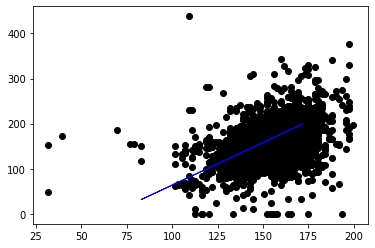

In [4]:
# Power will be target_variable
target_variable = 'power'
y = activity_df[target_variable].to_numpy().reshape(-1,1)
X = activity_df["hr"].to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=random_state, shuffle=True)
regressor = linear_model.LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(f"The coef. of determination is: {r2_score(y_test,y_pred)}")

plt.scatter(y_pred, y_test, color="black")
plt.plot(X_test,y_pred, color='blue', linewidth=1)
plt.show()

## OLS with multiple input variables
Power is still the target, but we take in HR, CAD, Elevation

The coef. of determination is: 0.1575645738645538


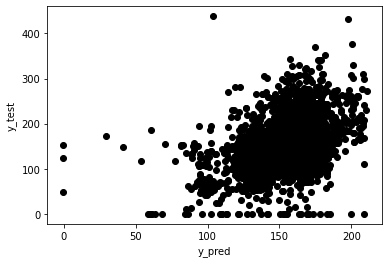

In [5]:
# Power will be target_variable
target_variable = 'power'
y = activity_df[target_variable]
X = activity_df.drop(columns=["name","time","lat","lon", "type","power"])
X.head()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.40, random_state=random_state, shuffle=True)
regressor = linear_model.LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(f"The coef. of determination is: {r2_score(y_test,y_pred)}")

plt.scatter(y_pred, y_test, color="black")
plt.xlabel("y_pred"), plt.ylabel("y_test")
plt.show()

In [6]:
def _calc_g(df):
    EARTH_RADIUS = 6378.137
    ONE_DEGREE_M = (2*np.pi*EARTH_RADIUS*1000)/360 #m/deg
    dx = df['lat'].rolling(window=2).apply(lambda x: ((x.iloc[1]-x.iloc[0])*ONE_DEGREE_M)**2)
    dy = df['lon'].rolling(window=2).apply(lambda x: ((x.iloc[1]-x.iloc[0])*ONE_DEGREE_M)**2)
    dz = df['ele'].rolling(window=2).apply(lambda x: x.iloc[1]-x.iloc[0])
    dxy = np.sqrt(dx+dy)
    g = np.degrees(np.arctan(dz/dxy))
    g[np.isnan(g)] = 0
    
    return g

def _calc_d(df):
    EARTH_RADIUS = 6378.137
    ONE_DEGREE_M = (2*np.pi*EARTH_RADIUS*1000)/360 #m/deg
    coef = df['lat'].rolling(window=2).apply(lambda x: np.cos(np.radians(x.iloc[1])))
    dx = df['lat'].rolling(window=2).apply(lambda x: x.iloc[1]-x.iloc[0])
    dy = df['lon'].rolling(window=2).apply(lambda x: x.iloc[1]-x.iloc[0]) * coef
    dz = df['ele'].rolling(window=2).apply(lambda x: x.iloc[1]-x.iloc[0])

    d_2d = np.sqrt(dx**2 + dy**2) * ONE_DEGREE_M

    # return d_2d
    return np.sqrt(d_2d**2 + dz**2)

def _calc_spd(df):

    df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%dT%H:%M:%SZ")
    df["elapsed_time"] = df["time"] - df.iloc[0].time
    df["elapsed_time_s"] = df["elapsed_time"]/np.timedelta64(1,'s')
    dt = df["elapsed_time_s"].rolling(window=2).apply(lambda x: x.iloc[1]-x.iloc[0])

    d = _calc_d(df)
    s = np.divide(d, df["elapsed_time_s"])
    s[np.isnan(s)] = 0

    return s


### bumps
- Add a calculated feature: Gradient
- standard scaler on X

The coef. of determination is: 0.3040177992149776


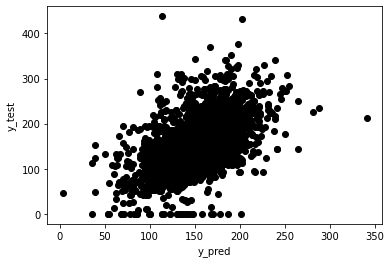

In [7]:
# Power will be target_variable
activity_df = pd.read_json((ACTIVITY_DIR+ACTIVITY_NAME))
activity_df.insert(loc=0,column='gradient', value=_calc_g(activity_df))
target_variable = 'power'
y = activity_df[target_variable]
activity_df = activity_df.drop(columns=["name","time","lat","lon", "type","power"])
X = activity_df

X = StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.40, random_state=random_state, shuffle=True)
regressor = linear_model.LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(f"The coef. of determination is: {r2_score(y_test,y_pred)}")

plt.scatter(y_pred, y_test, color="black")
plt.xlabel("y_pred"), plt.ylabel("y_test")
plt.show()

### Decision Tree Regressor
- add speed
- output feature importances

The coef. of determination is: 0.5270535971144228


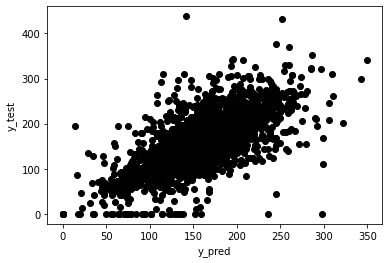

speed had importance 0.1320803352686111
gradient had importance 0.2690980653196278
cad had importance 0.14713726278176356
ele had importance 0.139708542658236
hr had importance 0.08967303171736515
elapsed_time_s had importance 0.22230276225439638


In [8]:
# Power will be target_variable
activity_df = pd.read_json((ACTIVITY_DIR+ACTIVITY_NAME))
activity_df.insert(loc=0,column='gradient', value=_calc_g(activity_df))
activity_df.insert(loc=0,column='speed', value=_calc_spd(activity_df))

target_variable = 'power'
y = activity_df[target_variable]
activity_df = activity_df.drop(columns=["name","time","elapsed_time","lat","lon", "type","power"])
# activity_df.head(19)
X = activity_df

X = StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.40, random_state=random_state, shuffle=True)
regressor = RandomForestRegressor(n_estimators=200, random_state=random_state)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(f"The coef. of determination is: {r2_score(y_test,y_pred)}")

plt.scatter(y_pred, y_test, color="black")
plt.xlabel("y_pred"), plt.ylabel("y_test")
plt.show()

for (name, importance) in zip(activity_df.columns, regressor.feature_importances_):
    print(f"{name} had importance {importance}")

## Build a pipeline to try multiple models in a compact manner
- get to clean solutions like https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline eventually but start with basic for looping.

Model #1: RandomForestRegressor(random_state=19)
The coef. of determination is: 0.528
Model #2: RandomForestRegressor(n_estimators=250, random_state=19)
The coef. of determination is: 0.533
Model #3: RandomForestRegressor(n_estimators=500, random_state=19)
The coef. of determination is: 0.536
Model #4: LinearRegression()
The coef. of determination is: 0.304
Model #5: KNeighborsRegressor()
The coef. of determination is: 0.527
Model #6: KNeighborsRegressor(weights='distance')
The coef. of determination is: 0.58
Model #7: KNeighborsRegressor(n_neighbors=7, weights='distance')
The coef. of determination is: 0.585
Model #8: KNeighborsRegressor(n_neighbors=9, weights='distance')
The coef. of determination is: 0.588
Model #9: MLPRegressor(hidden_layer_sizes=2048, max_iter=5000, random_state=19)
The coef. of determination is: 0.296


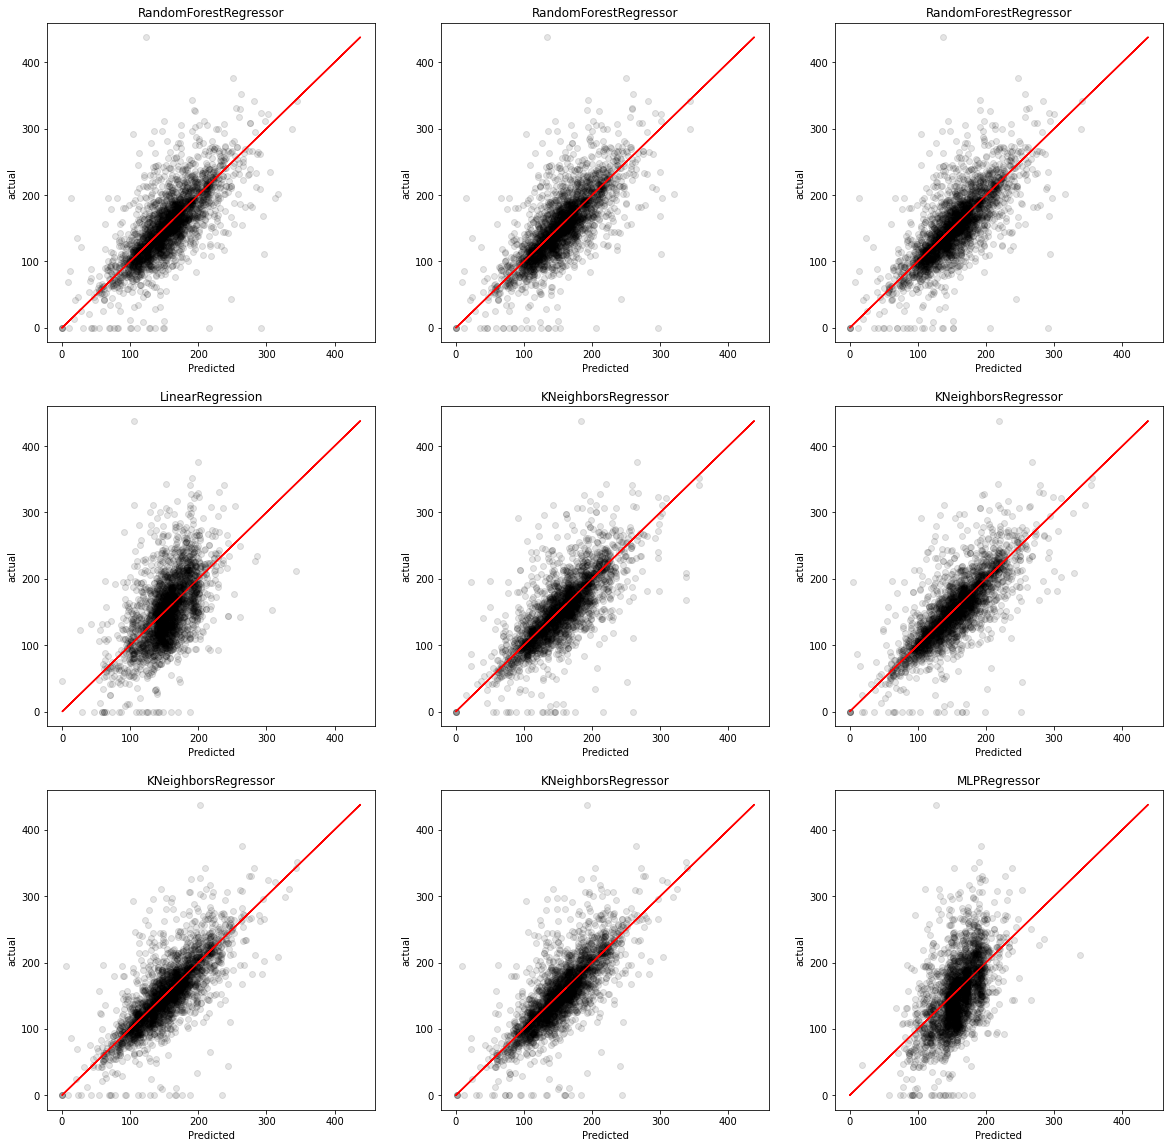

In [9]:
# Power will be target_variable
activity_df = pd.read_json((ACTIVITY_DIR+ACTIVITY_NAME))
activity_df.insert(loc=0,column='gradient', value=_calc_g(activity_df))
activity_df.insert(loc=0,column='speed', value=_calc_spd(activity_df))

target_variable = 'power'
y = activity_df[target_variable]
activity_df = activity_df.drop(columns=["name","time","elapsed_time","lat","lon", "type","power"])
# activity_df.head(19)
X = activity_df

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=random_state, shuffle=True)


models =[
        (
            RandomForestRegressor(n_estimators=100, random_state=random_state)
        ),
        (
            RandomForestRegressor(n_estimators=250, random_state=random_state)
        ),
        (
            RandomForestRegressor(n_estimators=500, random_state=random_state)
        ),
        (
            linear_model.LinearRegression()
        ),
        (
            sklearn.neighbors.KNeighborsRegressor(n_neighbors=5,weights='uniform')
        ),
        (
            sklearn.neighbors.KNeighborsRegressor(n_neighbors=5,weights='distance')
        ),
        (
            sklearn.neighbors.KNeighborsRegressor(n_neighbors=7,weights='distance')
        ),
        (
            sklearn.neighbors.KNeighborsRegressor(n_neighbors=9,weights='distance')
        ),
        (
            MLPRegressor(hidden_layer_sizes=(2048), max_iter=5000, random_state=random_state)
        )
        ]

fig = plt.figure(figsize=(20,20))
for i,regressor in enumerate(models):

    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(X_test)

    print(f"Model #{i+1}: {regressor}")
    print(f"The coef. of determination is: {r2_score(y_test,y_pred).round(3)}")
    plt.subplot(3,3,i+1)
    plt.scatter(y_pred, y_test, color="black", alpha=0.1)
    plt.plot(y_test, y_test,color='red')
    plt.xlabel("Predicted"), plt.ylabel("actual"), plt.title(regressor.__class__.__name__)
   
plt.show()


In [12]:

models =[
        (
            RandomForestRegressor(random_state=random_state),
            {"n_estimators":[100,200,400,500]}
        ),
        (
            sklearn.neighbors.KNeighborsRegressor(),
            {"n_neighbors":[1,3,5,7,9], "weights":["uniform","distance"]}
        )
        ]
        
grid = [
    {
        'Regressor': [reg],
        **{
            f'Regressor__{param}': values
            for param, values in reg_grid.items()
        }
    }
    for reg, reg_grid in models
]

print(grid)

[{'Regressor': [RandomForestRegressor(random_state=19)], 'Regressor__n_estimators': [100, 200, 400, 500]}, {'Regressor': [KNeighborsRegressor()], 'Regressor__n_neighbors': [1, 3, 5, 7, 9], 'Regressor__weights': ['uniform', 'distance']}]
